Total recipes: 543492
Unique cuisines: 258 | Unique categories: 733
               time  servings
count  5.434920e+05       0.0
mean   2.374541e+02       NaN
std    6.115851e+04       NaN
min    1.000000e+00       NaN
25%    2.000000e+01       NaN
50%    4.000000e+01       NaN
75%    7.000000e+01       NaN
max    4.355280e+07       NaN 



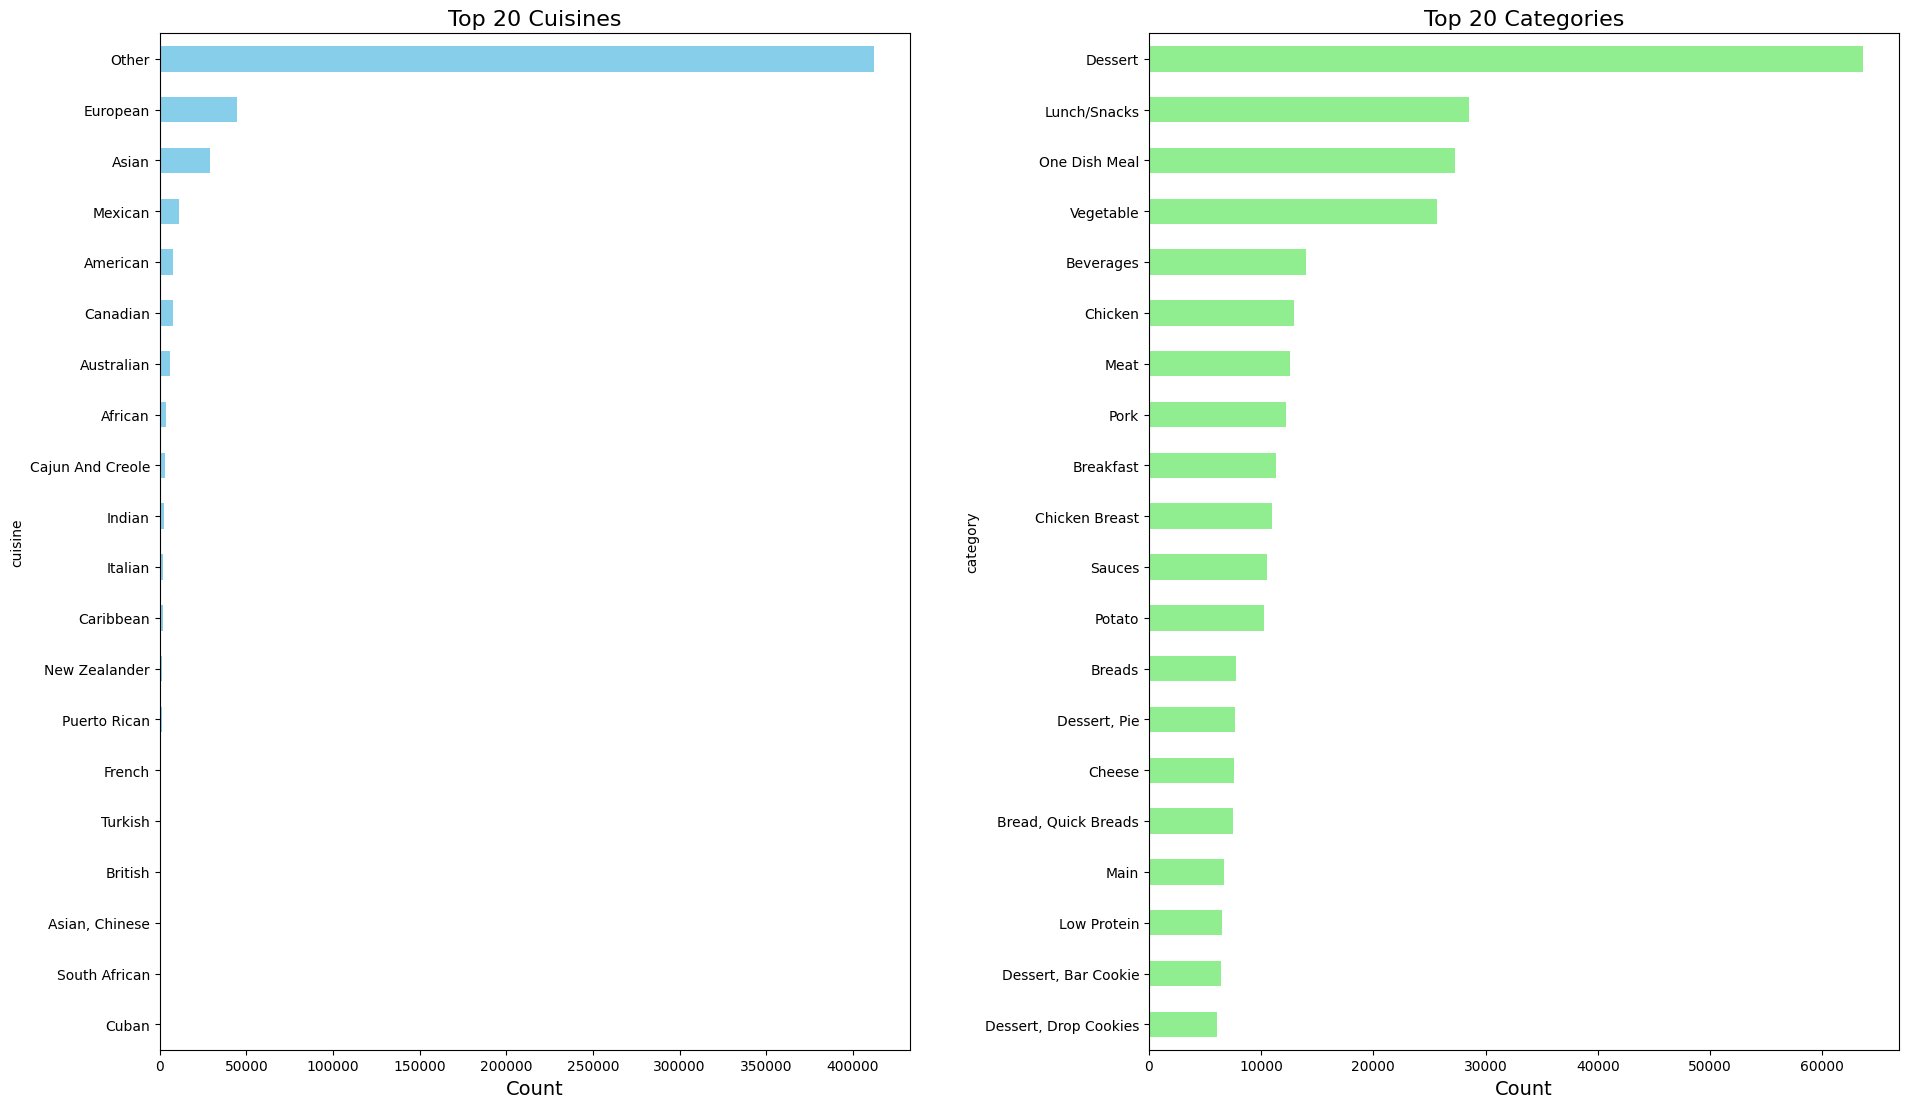

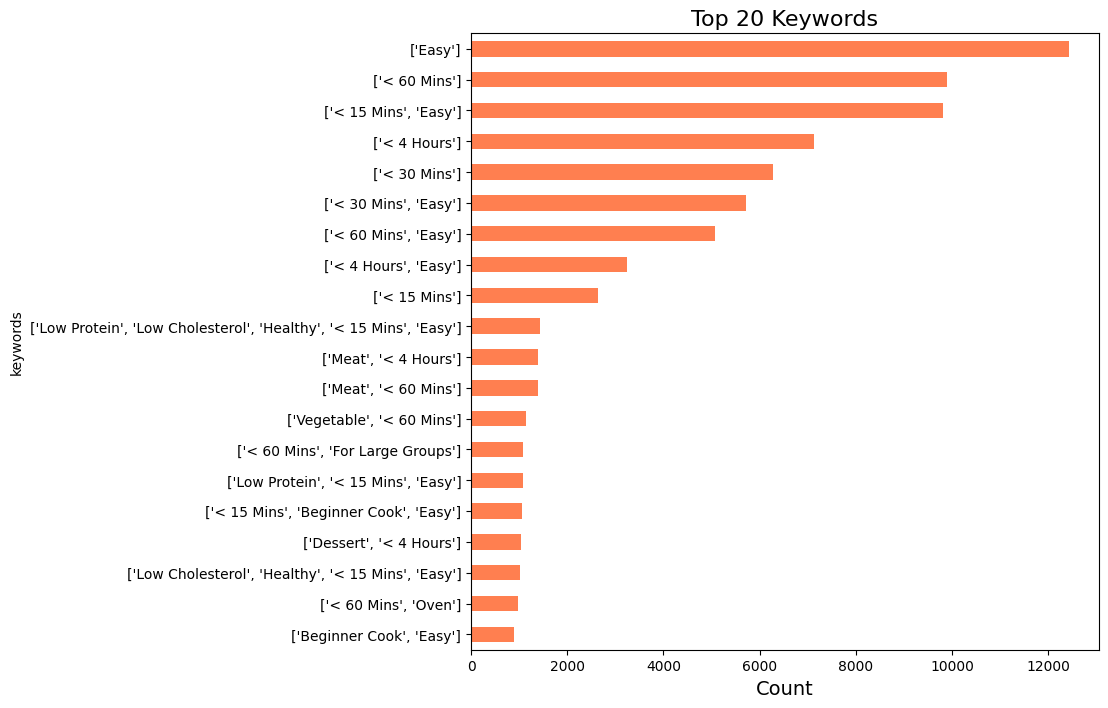

Top ingredients: ['1/2 teaspoon salt', '1 teaspoon salt', '1/4 teaspoon salt', 'salt and pepper', 'salt', '2 eggs', '1 egg', '1 teaspoon vanilla', '2 tablespoons olive oil', '1 tablespoon olive oil', '1 cup sugar', '1 teaspoon baking soda', '1 teaspoon vanilla extract', '2 tablespoons butter', '1/2 cup sugar', '1/4 teaspoon pepper', '2 garlic cloves, minced', 'pepper', '1 teaspoon baking powder', '1 cup water']


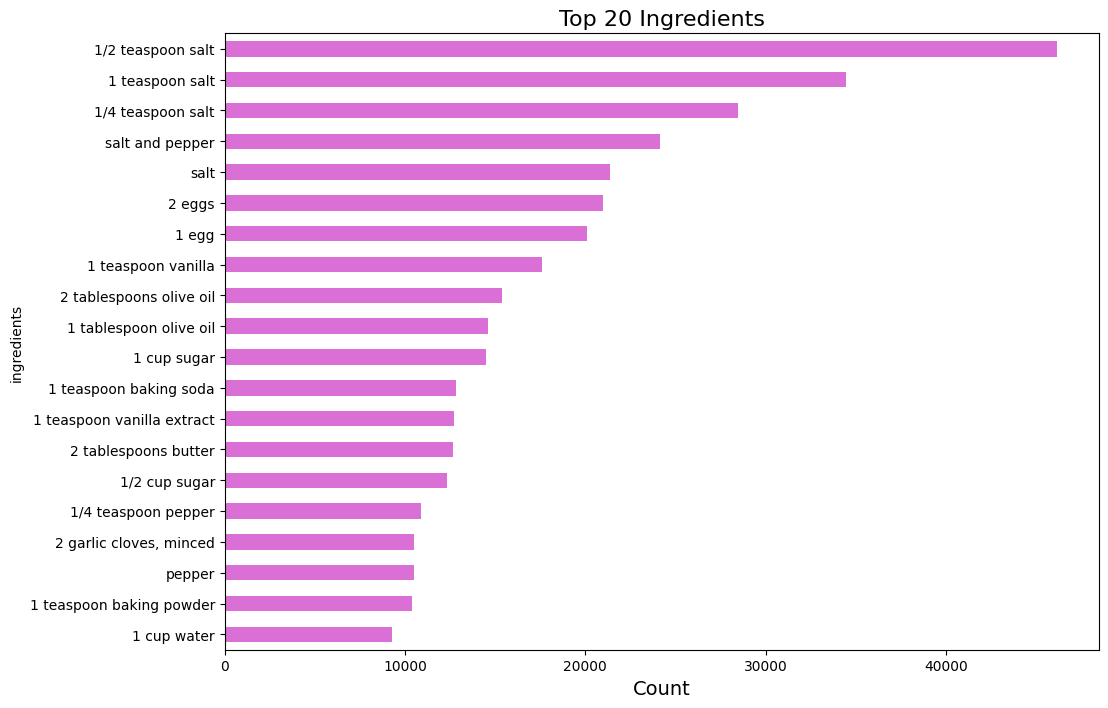

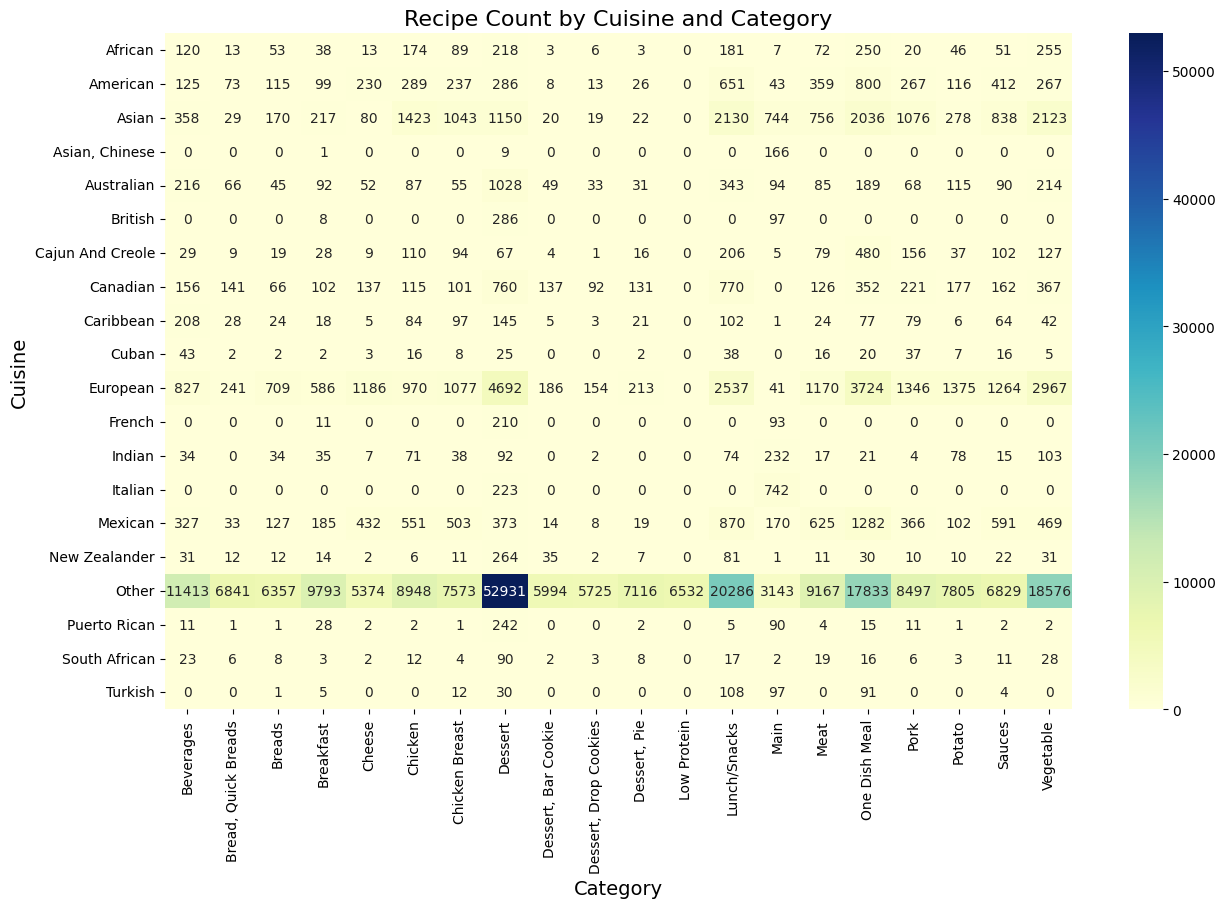

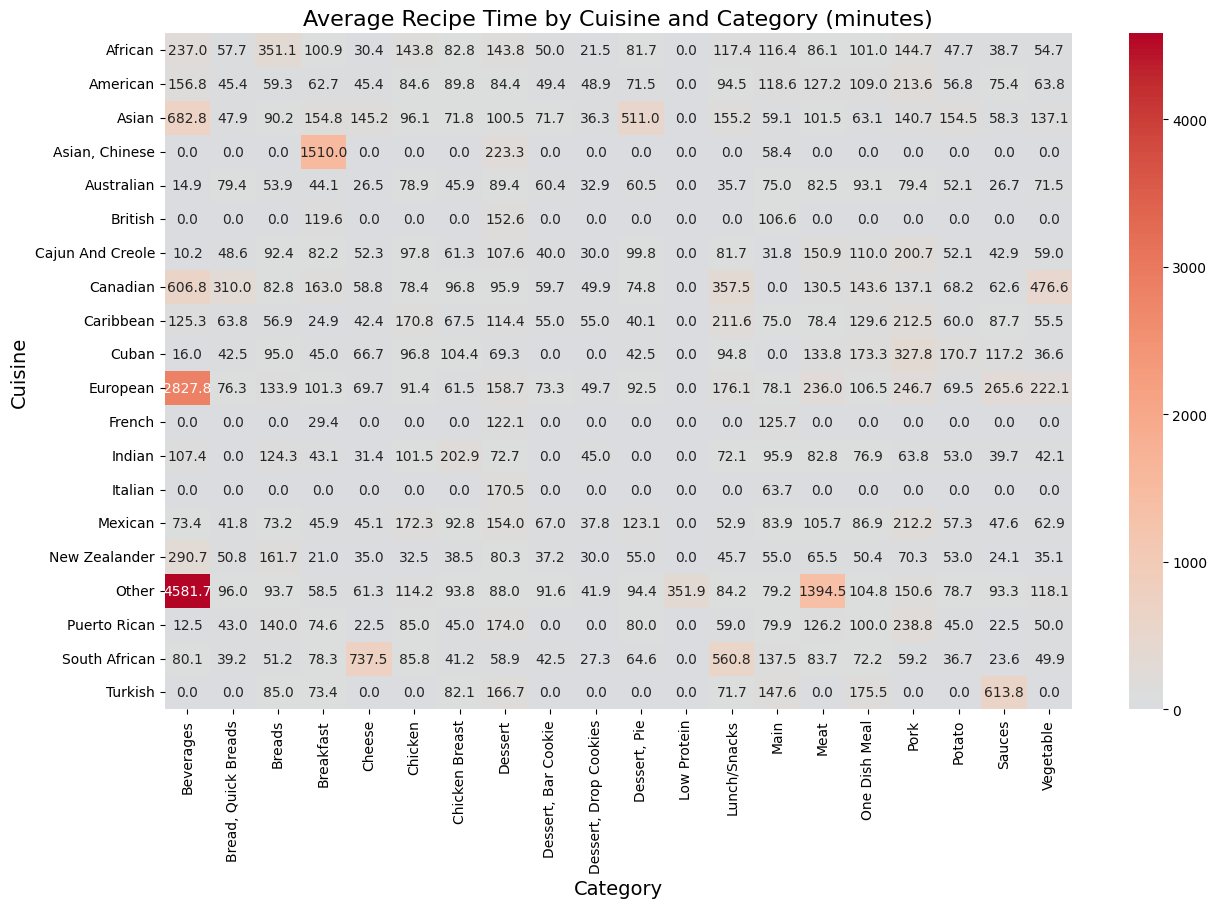

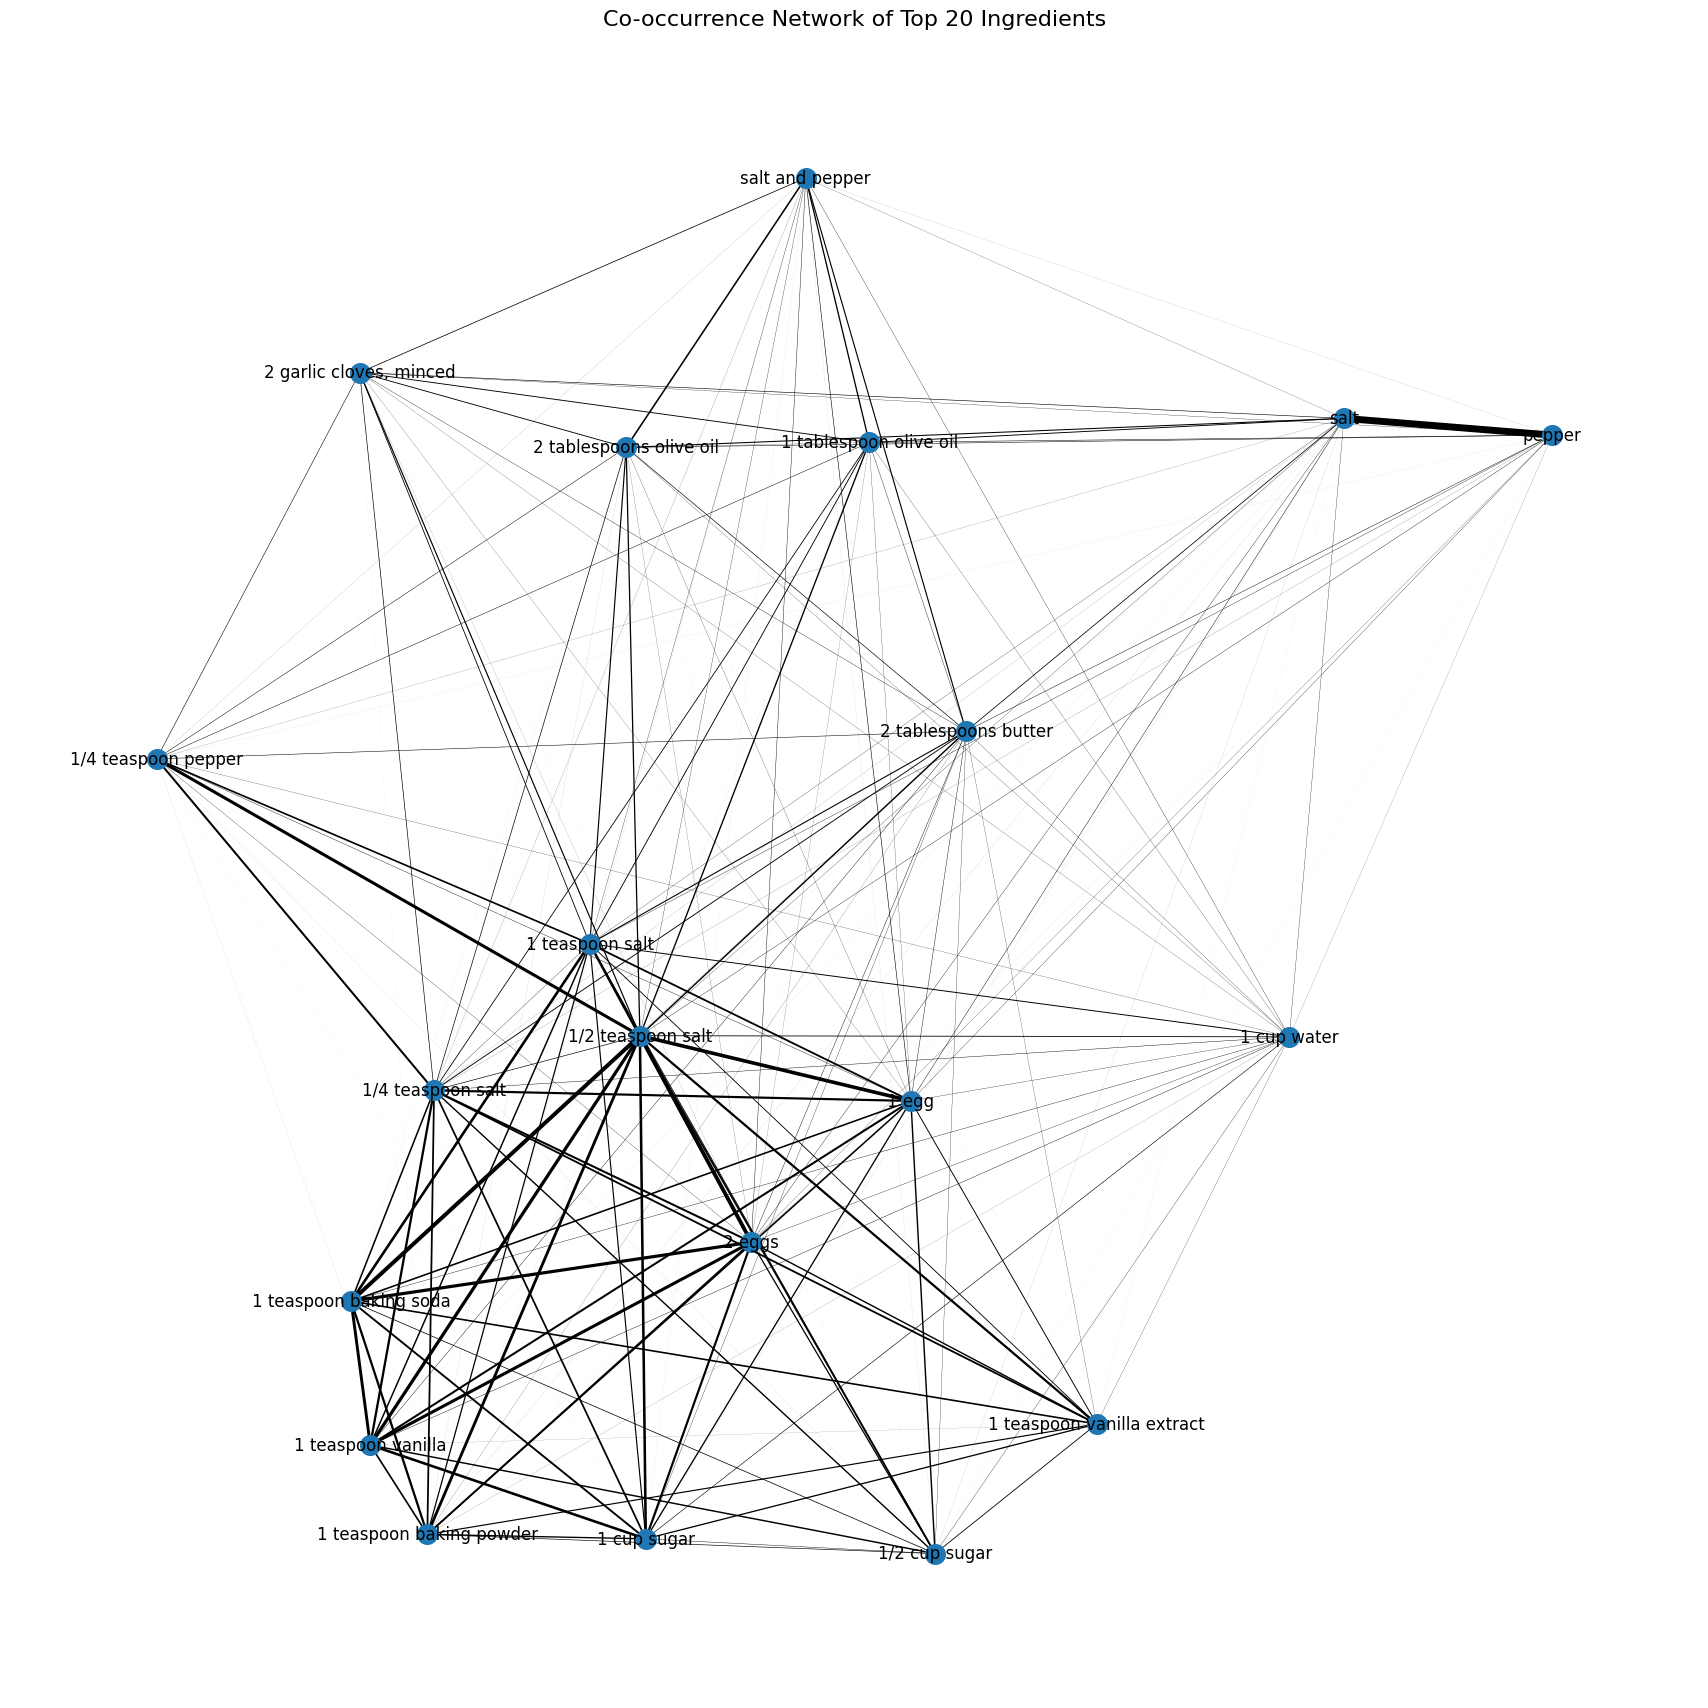

EDA complete. Subset saved to 'subset_recipes.csv'.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.colors as mcolors
from itertools import combinations

# -------------------------- PARAMETERS --------------------------
TOP_K_CUISINES = 20       # Number of top cuisines/categories to plot
TOP_K_KEYWORDS = 20       # Number of top keywords to plot
TOP_K_INGREDIENTS = 20    # Number of top ingredients to analyze
TOP_COOC_PAIRS = 20       # Number of top co-occurrence pairs to plot
# ----------------------------------------------------------------

# 1. LOAD & CLEAN DATA
csv_path = 'dataset.csv'  # adjust filename if needed

df = pd.read_csv(csv_path).rename(columns={
    'Cuisine': 'cuisine',
    'Category': 'category',
    'Total Time': 'time',
    'Servings': 'servings',
    'Keywords': 'keywords',
    'Ingredients': 'ingredients'
})
cols = ['cuisine', 'category', 'time', 'servings', 'keywords', 'ingredients']
df_sub = df[cols].dropna(subset=cols).copy()

# Convert numeric fields
df_sub['time'] = pd.to_numeric(df_sub['time'], errors='coerce')
df_sub['servings'] = pd.to_numeric(df_sub['servings'], errors='coerce')

# Parse ingredients column if stored as string
def parse_ings(x):
    if isinstance(x, str):
        try:
            return eval(x)
        except Exception:
            return [i.strip() for i in x.split(',')]
    return x

df_sub['ingredients'] = df_sub['ingredients'].apply(parse_ings)
df_sub.to_csv('subset_recipes.csv', index=False)

# 2. DESCRIPTIVE STATS
print(f"Total recipes: {len(df_sub)}")
print(f"Unique cuisines: {df_sub['cuisine'].nunique()} | Unique categories: {df_sub['category'].nunique()}")
print(df_sub[['time', 'servings']].describe(), "\n")

# 3. TOP CUISINES & CATEGORIES
top_cuisines = df_sub['cuisine'].value_counts().head(TOP_K_CUISINES)
top_categories = df_sub['category'].value_counts().head(TOP_K_CUISINES)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), dpi=100)
top_cuisines.plot.barh(ax=ax1, color='skyblue')
ax1.invert_yaxis()
ax1.set_title(f'Top {TOP_K_CUISINES} Cuisines', fontsize=16)
ax1.set_xlabel('Count', fontsize=14)
top_categories.plot.barh(ax=ax2, color='lightgreen')
ax2.invert_yaxis()
ax2.set_title(f'Top {TOP_K_CUISINES} Categories', fontsize=16)
ax2.set_xlabel('Count', fontsize=14)
plt.tight_layout(pad=4.0)
plt.show()

# 4. TOP KEYWORDS
keyword_counts = df_sub['keywords'].explode().value_counts().head(TOP_K_KEYWORDS)
plt.figure(figsize=(12, 8), dpi=100)
keyword_counts.plot.barh(color='coral')
plt.title(f'Top {TOP_K_KEYWORDS} Keywords', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout(pad=4.0)
plt.show()

# 5. TOP INGREDIENTS
ing_counts = df_sub['ingredients'].explode().value_counts().head(TOP_K_INGREDIENTS)
print("Top ingredients:", list(ing_counts.index))
plt.figure(figsize=(12, 8), dpi=100)
ing_counts.plot.barh(color='orchid')
plt.title(f'Top {TOP_K_INGREDIENTS} Ingredients', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout(pad=4.0)
plt.show()

# 6. CUISINE-CATEGORY COUNT HEATMAP
cuisines = top_cuisines.index
categories = top_categories.index
pivot_counts = (
    df_sub[df_sub['cuisine'].isin(cuisines) & df_sub['category'].isin(categories)]
    .pivot_table(index='cuisine', columns='category', values='time', aggfunc='count')
    .fillna(0)
)
plt.figure(figsize=(14, 10), dpi=100)
sns.heatmap(pivot_counts, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Recipe Count by Cuisine and Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Cuisine', fontsize=14)
plt.tight_layout(pad=4.0)
plt.show()

# 7. CUISINE-CATEGORY AVERAGE TIME HEATMAP
pivot_time = (
    df_sub[df_sub['cuisine'].isin(cuisines) & df_sub['category'].isin(categories)]
    .pivot_table(index='cuisine', columns='category', values='time', aggfunc='mean')
    .fillna(0)
)
plt.figure(figsize=(14, 10), dpi=100)
sns.heatmap(pivot_time, annot=True, fmt='.1f', cmap='coolwarm', center=pivot_time.values.mean())
plt.title('Average Recipe Time by Cuisine and Category (minutes)', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Cuisine', fontsize=14)
plt.tight_layout(pad=4.0)
plt.show()


# 7. INGREDIENT CO-OCCURRENCE NETWORK AMONG TOP INGREDIENTS
top_ings = set(ing_counts.index)
cooc = {}
for ings in df_sub['ingredients']:
    filtered = set(ings) & top_ings
    for a, b in combinations(sorted(filtered), 2):
        cooc[(a, b)] = cooc.get((a, b), 0) + 1
pairs = sorted(cooc.items(), key=lambda x: x[1], reverse=True)
G = nx.Graph()
max_w = pairs[0][1] if pairs else 1
for (a, b), count in pairs:
    G.add_edge(a, b, weight=count)

plt.figure(figsize=(18, 18), dpi=100)
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges()
weights = [G[u][v]['weight'] / max_w for u, v in edges]
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_edges(G, pos, width=[w * 5 for w in weights])
nx.draw_networkx_labels(G, pos, font_size=12)
plt.title(f'Co-occurrence Network of Top {TOP_K_INGREDIENTS} Ingredients', fontsize=16)
plt.axis('off')
plt.tight_layout(pad=4.0)
plt.show()

print("EDA complete. Subset saved to 'subset_recipes.csv'.") 